In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import datasets, transforms
import importlib
import model
importlib.reload(model)
from torch.utils.tensorboard import SummaryWriter
from torch import optim
import matplotlib.pyplot as plt
import random

In [2]:
dataDir = '../data/'
checkpointDir = '../checkpoints/'

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),])
train_set = torchvision.datasets.FashionMNIST(
    root=dataDir, train=True,  transform=transform)
test_set = torchvision.datasets.FashionMNIST(
    root=dataDir, train=False, transform=transform)
celoss = torch.nn.CrossEntropyLoss()

In [3]:
random.seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(42)

allExamples = []#np.zeros((10000,28*28)).astype(np.float32)
allLabels = []
size = 10000
unlab_size= 30000
for x in train_set :
    allExamples.append(x[0].flatten().numpy())
    allLabels.append(x[1])        
allExamples = np.array(allExamples)
allLabels = np.array(allLabels)
combinedExamples = np.concatenate([allExamples,allLabels[:,None]],axis=1)
np.random.shuffle(combinedExamples)
allExamples = combinedExamples[:size,:784]
unlabExamples = combinedExamples[size:(size+unlab_size), :784]
allLabels = combinedExamples[:size,-1]
testExamples = []#np.zeros((10000,28*28)).astype(np.float32)
testLabels = []

for x in test_set :
    testExamples.append(x[0].flatten().numpy())
    testLabels.append(x[1])        
testExamples = np.array(testExamples)
testLabels = np.array(testLabels)

In [5]:
forget_unlab= forget_unlab.cpu().numpy()
label_cnt= label_cnt.cpu().numpy()
chosen_unlab = (forget_unlab>1)
allExamples = np.concatenate([allExamples,unlabExamples[chosen_unlab,:]],axis=0)
allLabels = np.concatenate([allLabels, np.argmax(label_cnt[chosen_unlab,:], axis=1)],axis=0)

In [6]:
print (allExamples.shape)
print(unlabExamples.shape)

(20558, 784)
(30000, 784)


In [7]:
# combinedExamples = np.concatenate([allExamples,allLabels[:,None]],axis=1)
# combinedExamples = combinedExamples[combinedExamples[:,-1].argsort()]
# newExamples = []
# newLabels = []

# for i in range(len(combinedExamples)-1):
#     newExamples.append((combinedExamples[i,:784]+combinedExamples[i+1,:784])/2)
#     newLabels.append(combinedExamples[i,-1])
    
# newExamples.append(combinedExamples[i+1,:784])
# newLabels.append(combinedExamples[i+1,-1])

# allExamples = np.concatenate([allExamples,np.array(newExamples)],axis=0)
# allLabels = np.concatenate([allLabels,np.array(newLabels)],axis=0)

In [8]:
net = model.BasicNN().cuda()
optimizer = optim.SGD(net.parameters(), lr=0.01)
writer = SummaryWriter(log_dir = 'runs/run10K_forgetting_stats_on_unlabelled')
#writer = SummaryWriter(log_dir = 'runs/run10K_10KEUsimilarity')

batch_size = 100
max_epoch = 200
test_loss = []
train_loss = []

for epoch in range(max_epoch):
    epoch_tensor = torch.cuda.FloatTensor([epoch])
    shuff = torch.from_numpy(np.random.permutation(np.arange(len(allExamples))))
    net.train()
    for i in range(0,len(allExamples),batch_size):
        batch_ind = shuff[i:min(i+batch_size,len(allExamples))]
        inputs = torch.from_numpy(allExamples[batch_ind]).float().cuda()
        targets = torch.LongTensor(allLabels[batch_ind]).cuda()
        outputs = net(inputs)
        optimizer.zero_grad()
        loss = celoss(outputs, targets)
        loss.backward()
        optimizer.step()
        
    loss_,acc = 0,0
    with torch.no_grad():
        for i in range(0,len(testExamples),batch_size):
            batch_ind = np.arange(batch_size)+i
            inputs = torch.from_numpy(testExamples[batch_ind]).float().cuda()
            targets = torch.LongTensor(testLabels[batch_ind]).cuda()
            outputs = net(inputs)
            _, predicted = outputs.max(1)
            acc += (predicted==targets).sum().float()
            loss_ += celoss(outputs, targets).data*inputs.shape[0]
    writer.add_scalar('test/loss',loss_/len(testExamples),epoch)
    writer.add_scalar('test/acc',acc/len(testExamples),epoch)
    val_loss = loss_/len(testExamples)
    loss_,acc = 0,0
    with torch.no_grad():
        for i in range(0,len(allExamples),batch_size):
            batch_ind = shuff[i:min(i+batch_size,len(allExamples))]
            inputs = torch.from_numpy(allExamples[batch_ind]).float().cuda()
            targets = torch.LongTensor(allLabels[batch_ind]).cuda()
            outputs = net(inputs)
            _, predicted = outputs.max(1)
            acc += (predicted==targets).sum().float()
            loss_ += celoss(outputs, targets).data*inputs.shape[0]
    writer.add_scalar('train/loss',loss_/len(allExamples),epoch)
    writer.add_scalar('train/acc',acc/len(allExamples),epoch)
    writer.add_scalar('generalisation_error',(val_loss-loss_/len(allExamples)),epoch)

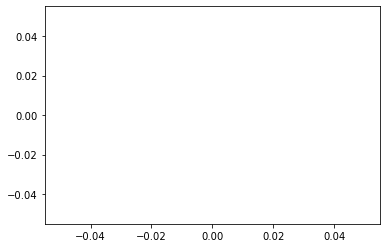

In [11]:
# plt.plot(np.array(test_loss))
# plt.plot(np.array(train_loss))
plt.plot(np.array(test_loss)-np.array(train_loss))

In [4]:

# binaryExamples = []#np.zeros((10000,28*28)).astype(np.float32)
# binaryLabels = []

# for x in train_set :
#     if (x[1] == 0 or x[1] == 1):
#         binaryExamples.append(x[0].flatten().numpy())
#         binaryLabels.append(x[1])        
# binaryExamples = np.array(binaryExamples)
# binaryLabels = np.array(binaryLabels)

# indices = np.concatenate([np.where(binaryLabels==0)[0][:5000],np.where(binaryLabels==1)[0][:5000]])
# binaryExamples = binaryExamples[indices]
# binaryLabels = binaryLabels[indices]


predictions = torch.from_numpy(np.zeros(len(allExamples))).float().cuda()
num_tries = torch.from_numpy(np.zeros(len(allExamples))).float().cuda()
first_learning = torch.from_numpy(np.zeros(len(allExamples))).float().cuda()+np.inf
inf_tensor = torch.cuda.FloatTensor([float('inf')])

net = model.BasicNN().cuda()
optimizer = optim.SGD(net.parameters(), lr=0.01)

batch_size = 100
max_epoch = 200
test_loss = []
train_loss = []
prev_unlab_pred = torch.from_numpy(np.zeros(len(unlabExamples))).long().cuda()
forget_unlab = torch.from_numpy(np.zeros(len(unlabExamples))).float().cuda()
label_cnt = torch.from_numpy(np.zeros((len(unlabExamples),10))).float().cuda()


for epoch in range(max_epoch):
    epoch_tensor = torch.cuda.FloatTensor([epoch])
    shuff = torch.from_numpy(np.random.permutation(np.arange(len(allExamples))))
    net.train()
    for i in range(0,len(allExamples),batch_size):
        batch_ind = shuff[i:i+batch_size]
        inputs = torch.from_numpy(allExamples[batch_ind]).float().cuda()
        targets = torch.LongTensor(allLabels[batch_ind]).cuda()
        outputs = net(inputs)
        optimizer.zero_grad()
        loss = celoss(outputs, targets)
        loss.backward()
        optimizer.step()

        ###########this part maintains forgetting stats#################                                                                                                                                                                  
        _, predicted = outputs.max(1)
        old_predictions = predictions[batch_ind]
        new_predictions = predicted.eq(targets).float()
        diff_pred = old_predictions - new_predictions
        num_tries[batch_ind[(diff_pred > 0).nonzero()]] += 1
        predictions[batch_ind] = new_predictions
        ###########this part maintains first learning event##############                                                                                                                                                                 
        new_predictions = torch.where(new_predictions == 1,epoch_tensor,inf_tensor)
        first_learning[batch_ind],_ = torch.min(torch.stack((first_learning[batch_ind],new_predictions)),dim=0)
    
    with torch.no_grad():
        for j in range(0,len(unlabExamples),batch_size):
            unlab_ind = torch.from_numpy(np.asarray(list(range(j,(j+min(batch_size, len(unlabExamples)))))))
            inputs = torch.from_numpy(unlabExamples[unlab_ind]).float().cuda()
            outputs = net(inputs)
            _, predicted = outputs.max(1)
            if i>0:
                ind = unlab_ind[predicted != prev_unlab_pred[unlab_ind]]
                forget_unlab[ind] += 1                
            label_cnt[unlab_ind,predicted] += 1
            prev_unlab_pred[unlab_ind] = predicted
